# Deep Learning Approach: Neural Network with TensorFlow

## Overview

This notebook implements a deep learning approach using a feedforward neural network:
1. **Sequence Padding**: Standardize sequence lengths
2. **Embedding Layer**: Learn word representations (or use pre-trained)
3. **Neural Network**: Multi-layer feedforward network
4. **Training**: With early stopping and validation monitoring

## Why Deep Learning?

- **Learned Representations**: Automatically learns feature representations
- **Complex Patterns**: Can capture non-linear relationships
- **Scalability**: Benefits from large datasets
- **State-of-the-art**: Often achieves better performance on complex tasks


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
# Load data
with open('../imdb_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train_encoded']
X_test = data['X_test_encoded']
y_train = data['y_train']
y_test = data['y_test']
word_index = data['word_index']

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Vocabulary size: {len(word_index)}")


Training samples: 25000
Test samples: 25000
Vocabulary size: 88584


## Sequence Padding

Neural networks require fixed-length inputs. We'll pad sequences to a maximum length.


In [3]:
# Pad sequences to fixed length
max_length = 500  # Maximum review length
vocab_size = 10000  # Vocabulary size

X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

print(f"Training sequences shape: {X_train_padded.shape}")
print(f"Test sequences shape: {X_test_padded.shape}")


Training sequences shape: (25000, 500)
Test sequences shape: (25000, 500)


## Build Neural Network Model

We'll create a feedforward neural network with:
- Embedding layer (learns word representations)
- Dense layers with dropout for regularization
- Output layer with sigmoid activation for binary classification


In [4]:
# Build model
model = keras.Sequential([
    # Embedding layer: converts word indices to dense vectors
    layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),
    
    # Flatten to feed into dense layers
    layers.Flatten(),
    
    # Dense layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    
    # Output layer
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 flatten (Flatten)           (None, 64000)             0         
                                                                 
 dense (Dense)               (None, 128)               8192128   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

## Train the Model

We'll use early stopping to prevent overfitting and monitor validation performance.


In [5]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train model
print("Training neural network...")
start_time = time.time()

history = model.fit(
    X_train_padded, y_train,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

training_time = time.time() - start_time
print(f"\nTraining complete in {training_time:.2f} seconds")


Training neural network...
Epoch 1/10


625/625 [==============================] - 14s 21ms/step - loss: 0.4939 - accuracy: 0.7336 - val_loss: 0.3318 - val_accuracy: 0.8684
Epoch 2/10
625/625 [==============================] - 13s 20ms/step - loss: 0.1657 - accuracy: 0.9412 - val_loss: 0.3839 - val_accuracy: 0.8556
Epoch 3/10
625/625 [==============================] - 13s 21ms/step - loss: 0.0309 - accuracy: 0.9908 - val_loss: 0.6745 - val_accuracy: 0.8442
Epoch 4/10
625/625 [==============================] - 11s 18ms/step - loss: 0.0153 - accuracy: 0.9946 - val_loss: 0.7850 - val_accuracy: 0.8418

Training complete in 50.69 seconds


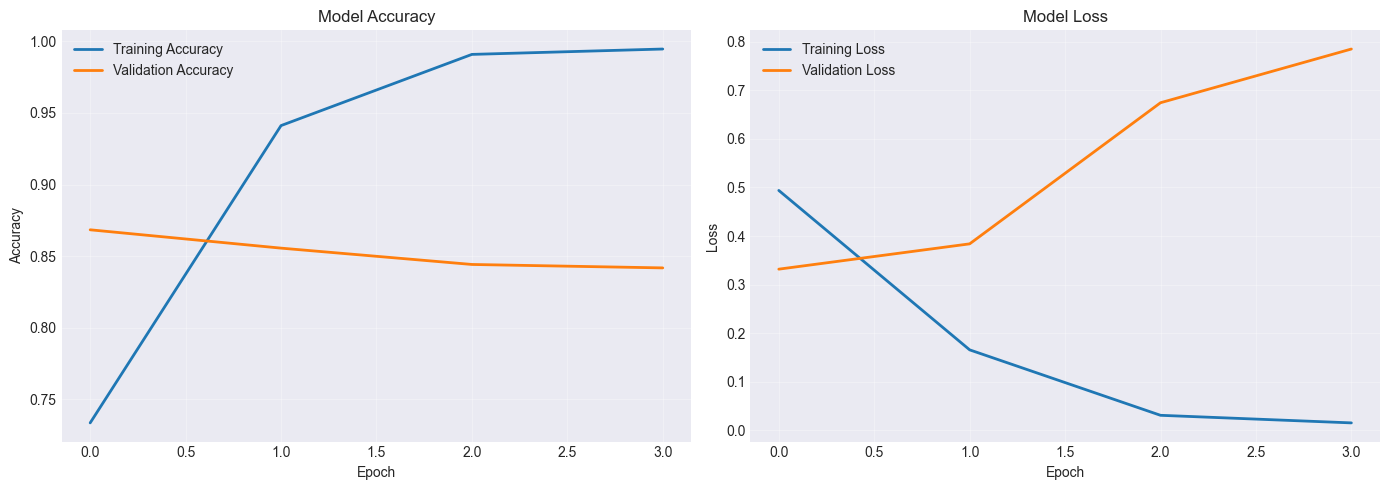

In [6]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
# Evaluate on test set
y_pred_proba = model.predict(X_test_padded)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


782/782 [==============================] - 2s 2ms/step
Test Accuracy: 0.8558

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.85      0.86     12500
    Positive       0.85      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



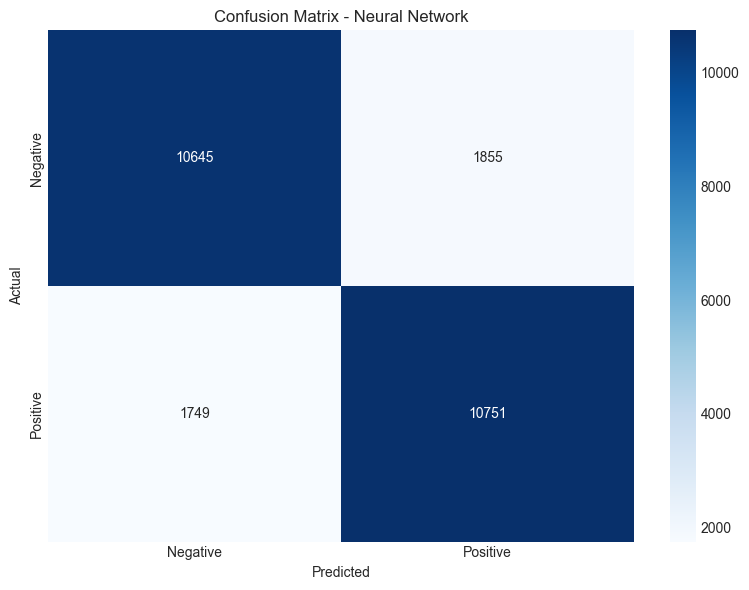

In [8]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.tight_layout()
plt.show()


In [9]:
# Save results
results_deep = {
    'accuracy': accuracy,
    'training_time': training_time,
    'history': history.history,
    'model': model
}

with open('../results_deep.pkl', 'wb') as f:
    pickle.dump(results_deep, f)

print("Results saved to '../results_deep.pkl'")
print(f"\nSummary:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  Training Time: {training_time:.2f} seconds")
print(f"  Epochs Trained: {len(history.history['loss'])}")


Results saved to '../results_deep.pkl'

Summary:
  Accuracy: 0.8558
  Training Time: 50.69 seconds
  Epochs Trained: 4
